In [20]:
from __future__ import print_function
from __future__ import division
import calendar
from collections import defaultdict, OrderedDict
import datetime
import dateutil.parser as dparser
from glob import glob
import logging
import matplotlib.pyplot as plt
import matplotlib.path as mplpath
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import os
import pandas as pd
import skimage
import skimage.io as skio
from skimage import draw
import subprocess
import time
import ujson as json

from optical_vessel_detection.core import img_utils as iutils
from optical_vessel_detection.core import planet_utils as putils
from optical_vessel_detection.core.annotation_utils import get_labeled_props

from optical_vessel_detection.support.regions import approximate_simplified_nk_eez, full_study_area
from optical_vessel_detection.support import notebook_utils
from optical_vessel_detection.support.notebook_utils import path2sceneid, path2datestr
from optical_vessel_detection.support import detection_metrics
from optical_vessel_detection.support.info import fully_annotated
from optical_vessel_detection.support import counting_tools

%matplotlib inline

proj_id = os.environ['PROJ_ID']

## Process/Load Info

These instructions are specific to GFW's setup. You will need to adapt this
your specific situation. 

In [21]:
scene_map = notebook_utils.create_scene_map(
    f'{proj_id}.machine_learning_production.planet_scene_info')

detections_map = notebook_utils.create_detections_map(
    f'{proj_id}.machine_learning_production.detected_pair_trawlers_1_1_aug')

paths = (
    glob("../../../../image-vessel-identification/data/paper/aoi_annotations_rnd1/*.png")           
  + glob('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd2/*.tif')
  + glob('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd3/*.tif')
      )

annotations_map = notebook_utils.create_annotations_map(paths, 
                                              'gs://machine-learning-production/planet_images/nk_detection/',
                                              f'{proj_id}:machine_learning_dev_ttl_120d.annotations_20')

Downloading: 100%|██████████| 4941/4941 [00:01<00:00, 4893.82rows/s]


20170627
20170806
20171024
20180514
20180602
20180715
20180731
20180826
20180911
20180917
20180929
Skipping 20180929_010750_104e
20181008
Skipping 20181008_013024_1008
Skipping 20181008_013026_1008
20181102


## True Positives, False Positives, and False Negatives

In [22]:
class Detection(detection_metrics.Detection):
    annotations = annotations_map
    detections = detections_map
    scenes = scene_map
    annotation_path_templates = [
        '../../../../image-vessel-identification/data/paper/aoi_annotations_rnd1/{}_3B_Visual.png',
        '../../../../image-vessel-identification/data/paper/aoi_annotations_rnd2/{}_3B_Visual.tif',
        '../../../../image-vessel-identification/data/paper/aoi_annotations_rnd3/{}_3B_Visual.tif'
    ]
    
Detection.metrics_for_scene_ids(['20181008_012620_1035'])

{'precision': 0.9354838709677419,
 'recall': 0.9354838709677419,
 'n_predicted': 31,
 'n_annotated': 31,
 'n_true_positives': 29,
 'n_false_positives': 2,
 'n_fp_single_trawler': 1,
 'n_fp_other_boat': 1,
 'n_scenes': 1,
 'area_km2': 216.4572915536537}

### What's Happening on 2017-06-27

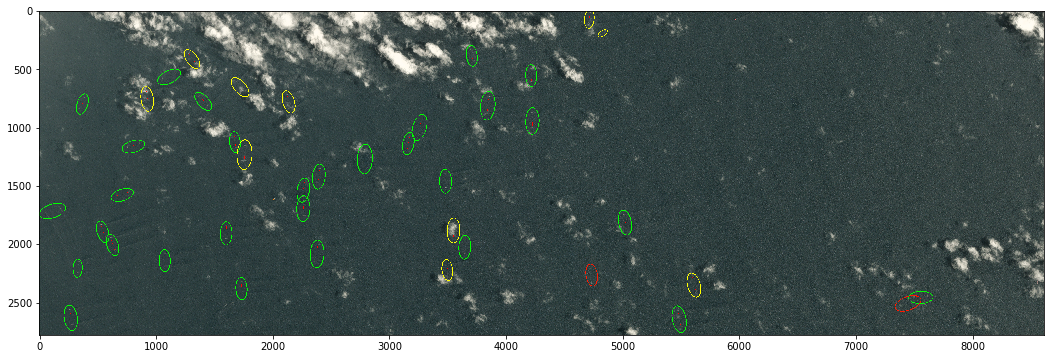

In [23]:
Detection.plot_detections_for_path('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd2/20170627_011133_1014_3B_Visual.tif', dilations=3)

It appears that the patchy clouds are supressing vessel detections. It is likely that
this is a result of an effort to suppress false positives due to patchy clouds that 
resulted in many negative examples of patchy clouds being included in the training set.

This is in contrast to a scene on a clear day, where most of the false negatives are associated
with being too near other trawler pairs (see below).

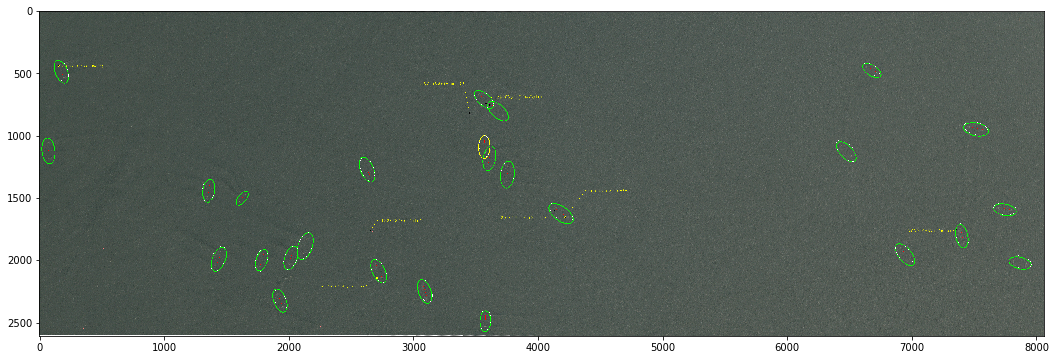

In [24]:
Detection.plot_detections_for_path('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd1/20180602_012906_0f2d_3B_Visual.png', dilations=3)

This is not a general problem with clouds. The model performs quite well with many types of clouds
(see below).  However certain subtypes of clouds do supress detections.  As always, this could likley be 
improved with  more training data

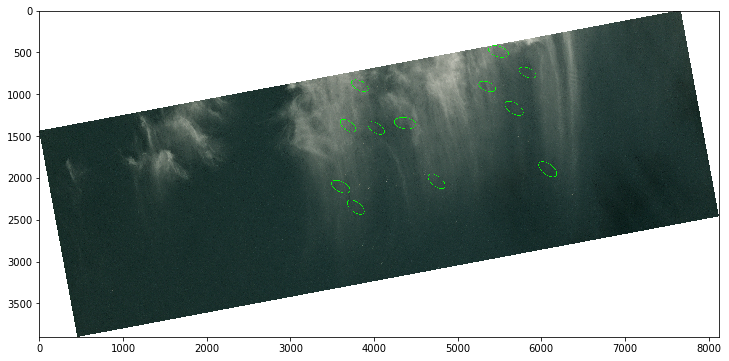

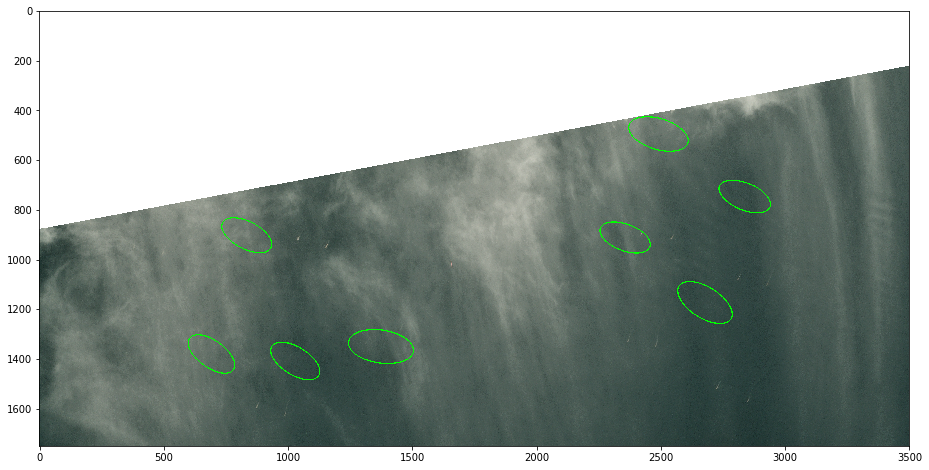

In [25]:
Detection.plot_detections_for_path(
 '../../../../image-vessel-identification/data/paper/scene_info/20181008_010604_1052_3B_Visual.tif',
    dilations=3)
img = Detection.overlay_detections_for_path(
 '../../../../image-vessel-identification/data/paper/scene_info/20181008_010604_1052_3B_Visual.tif', 
    dilations=2)
plt.figure(figsize=(16, 8))
plt.imshow(img[:1750, 3000:6500])

The most problematical weather is choppy seas, which can generate false positives over a
large area. The next is certain kinds of small clouds. See `20171105_012757_0f38` and 
`20171105_011118_0f34` for examples.

## Precision and Recall

We can also use `Detection` to compute false positives, 
true positives, etc.

In [26]:
scene_ids_20171024 = sorted(set([os.path.basename(x).rsplit('_', 2)[0] for x in 
         glob('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd1/20171024*.png') +
         glob('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd2/20171024*.tif') + 
         glob('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd3/20171024*.tif')
        ]))
metrics_20171024 = Detection.metrics_for_scene_ids(scene_ids_20171024)
metrics_20171024

{'precision': 0.9333333333333333,
 'recall': 0.937799043062201,
 'n_predicted': 210,
 'n_annotated': 209,
 'n_true_positives': 196,
 'n_false_positives': 14,
 'n_fp_single_trawler': 1,
 'n_fp_other_boat': 0,
 'n_scenes': 90,
 'area_km2': 19116.48554193906}

In [27]:
precision = metrics_20171024['precision'] 
recall = metrics_20171024['recall'] 
f1 = 2.0 / (1 / precision + 1 / recall)
print("20171024: P = {:.2f}, R = {:.2f}, F1 = {:.2f}".format(precision, recall, f1))

20171024: P = 0.93, R = 0.94, F1 = 0.94


In [28]:
all_scene_ids = []
for x in fully_annotated:
    if x.startswith('20171024'):
        # We used 20171024 to tune non max suppression and test new version, so
        # Exclude from overall R/P calculation
        print('Skipping 20171024 since it was used to tune non max supression')
        continue
    all_scene_ids += [os.path.basename(x).rsplit('_', 2)[0] for x in 
      glob('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd1/{}*.png'.format(x)) + 
      glob('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd2/{}*.tif'.format(x)) + 
      glob('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd3/{}*.tif'.format(x))
     ]
all_scene_ids = sorted(set([x for x in all_scene_ids if x not in notebook_utils.BAD_SCENES]))
metric_cumulative = Detection.metrics_for_scene_ids(all_scene_ids)
metric_cumulative

Skipping 20171024 since it was used to tune non max supression


{'precision': 0.9194244604316547,
 'recall': 0.9038189533239038,
 'n_predicted': 1390,
 'n_annotated': 1414,
 'n_true_positives': 1278,
 'n_false_positives': 112,
 'n_fp_single_trawler': 39,
 'n_fp_other_boat': 13,
 'n_scenes': 382,
 'area_km2': 78817.17387098986}

In [29]:
precision = metric_cumulative['precision']
recall = metric_cumulative['recall']
f1 = 2.0 / (1 / precision + 1 / recall)
print("Overall (excluding training and 1024) P = {:.2f}, R = {:.2f}, F1 = {:.2f}".format(precision, recall, f1))

Overall (excluding training and 1024) P = 0.92, R = 0.90, F1 = 0.91
